# CREDIT RISK CLSSIFIER

This project focuses on classifying bank clients into 'risk' or 'no risk' categories to determine their creditworthiness. Using machine learning, the model analyzes client data to predict the likelihood of default, helping banks make informed lending decisions.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import shapiro, normaltest 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE 


## Data Description

In [3]:
data = pd.read_csv("bank_data.csv", index_col = 0)
data = data.drop(columns=['support_indicator '])
data.head()

,age,income,children,credit_history,overdue_payments,active_loans,years_in_job,employment_type,owns_property,assets_value,other_loans,education,city,marital_status,credit_risk
0,44,15689 złoty,brak,dobra historia,brak opóźnień,2,9,samozatrudnienie,NaN,NaN,1,wyższe,małe,żonaty/zamężna,0
1,38,18906 złoty,4 dzieci,brak historii,brak opóźnień,0,1,stała,tak,62965 złoty,0,średnie,średnie,kawaler/panna,0
2,46,16338 złoty,2 dzieci,NaN,NaN,2,4,brak,tak,124967 złoty,0,podstawowe,duże,żonaty/zamężna,0
3,55,23276 złoty,3 dzieci,dobra historia,opóźnienia,2,10,stała,tak,52147 złoty,1,średnie,małe,kawaler/panna,0
4,37,40000 złoty,1 dzieci,brak historii,NaN,1,9,określona,nie,33957 złoty,1,wyższe,małe,kawaler/panna,0


- age - Age of the client (years) 
- income - Annual income of the client (with "złoty" added as currency) 
- children - Number of children the client has; 0 is encoded as "none" 
- credit_history - Credit history status: "no history," "good history," "bad history" 
- overdue_payments -  Status of overdue payments: "no overdue" or "overdue" 
- active_loans - Number of active loans held by the client 
- years_in_job - Number of years in current employment 
- employment_type - Employment status (e.g., "self-employed," "permanent") 
- owns_property - Whether the client owns property: "yes" or "no" 
- assets_value - Value of assets owned (with "złoty" as currency) 
- other_loans - Number of other loans held by the client 
- education - Education level (e.g., "higher," "secondary") 
- city - Size category of the city of residence (e.g., "small," "medium," "large") 
- marital_status - Marital status of the client 
- support_indicator - An auxiliary metric introduced in data generation 
- credit_risk - Target variable: 0 (low risk) or 1 (high risk)

## Data Preprocessing

### Missing Values

In [4]:
data.isna().sum()

age                    0
income              2000
children               0
credit_history      2000
overdue_payments    2000
active_loans           0
years_in_job           0
employment_type        0
owns_property       2000
assets_value        2000
other_loans            0
education              0
city                   0
marital_status         0
credit_risk            0
dtype: int64

### Unique values for categorical columns

In [10]:
unique_values = {col: data[col].unique() for col in ["children", "credit_history", "employment_type", "owns_property", "education", "city", "marital_status"]}
pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values.items()]))

,children,credit_history,employment_type,owns_property,education,city,marital_status
0,brak,dobra historia,samozatrudnienie,NaN,wyższe,małe,żonaty/zamężna
1,4 dzieci,brak historii,stała,tak,średnie,średnie,kawaler/panna
2,2 dzieci,NaN,brak,nie,podstawowe,duże,rozwiedziony/rozwiedziona
3,3 dzieci,NaN,określona,NaN,NaN,NaN,NaN
4,1 dzieci,NaN,NaN,NaN,NaN,NaN,NaN
5,5 dzieci,NaN,NaN,NaN,NaN,NaN,NaN


### Columns Label Encoding

In [11]:
data["income"] = data["income"].str.replace("złoty", "").astype(float)

data["children"] = data["children"].str.replace("dzieci", "")
data["children"] = data["children"].str.replace("brak", "0").astype(int)

data["credit_history"] = data["credit_history"].str.replace("dobra historia", "1").str.replace("brak historii", "0")
data["credit_history"] = data["credit_history"].astype("Int64")

data["overdue_payments"] = data["overdue_payments"].str.replace("brak opóźnień", "0").str.replace("opóźnienia", "1").str.replace("2", "1").str.replace("3", "1").str.replace("4", "1")
data["overdue_payments"] = data["overdue_payments"].astype("Int64")

data["employment_type"] = data["employment_type"].str.replace("brak", "0").str.replace("określona", "1").str.replace("samozatrudnienie", "2").str.replace("stała", "3")
data["employment_type"] = data["employment_type"].astype("Int64")

data["owns_property"] = data["owns_property"].str.replace("nie", "0").str.replace("tak", "1")
data["owns_property"] = data["owns_property"].astype("Int64")

data["assets_value"] = data["assets_value"].str.replace("złoty", "").astype(float)

data["education"] = data["education"].str.replace("podstawowe", "0").str.replace("średnie", "1").str.replace("wyższe", "2").astype(int)

data["city"] = data["city"].str.replace("małe", "0").str.replace("średnie", "1").str.replace("duże", "2").astype(int)

data["marital_status"] = data["marital_status"].str.replace("kawaler/panna", "0").str.replace("żonaty/zamężna", "1").str.replace("rozwiedziony/rozwiedziona", "2").astype(int)


### Basic Statistics

In [7]:
data[['age','income','children','active_loans','years_in_job','assets_value']].describe()

,age,income,children,active_loans,years_in_job,assets_value
count,10000.000000,8000.000000,10000.000000,10000.000000,10000.000000,8000.000000
mean,39.527000,23598.621250,0.983600,1.497900,9.524300,80349.420250
std,9.874899,9717.329753,1.235105,1.223824,4.869803,70517.033919
min,18.000000,3202.000000,0.000000,0.000000,0.000000,10000.000000
25%,33.000000,15778.000000,0.000000,1.000000,6.000000,34335.250000
50%,39.000000,22083.000000,0.000000,1.000000,9.000000,59565.000000
75%,46.000000,31066.500000,2.000000,2.000000,13.000000,102015.000000
max,70.000000,40000.000000,5.000000,8.000000,30.000000,500000.000000


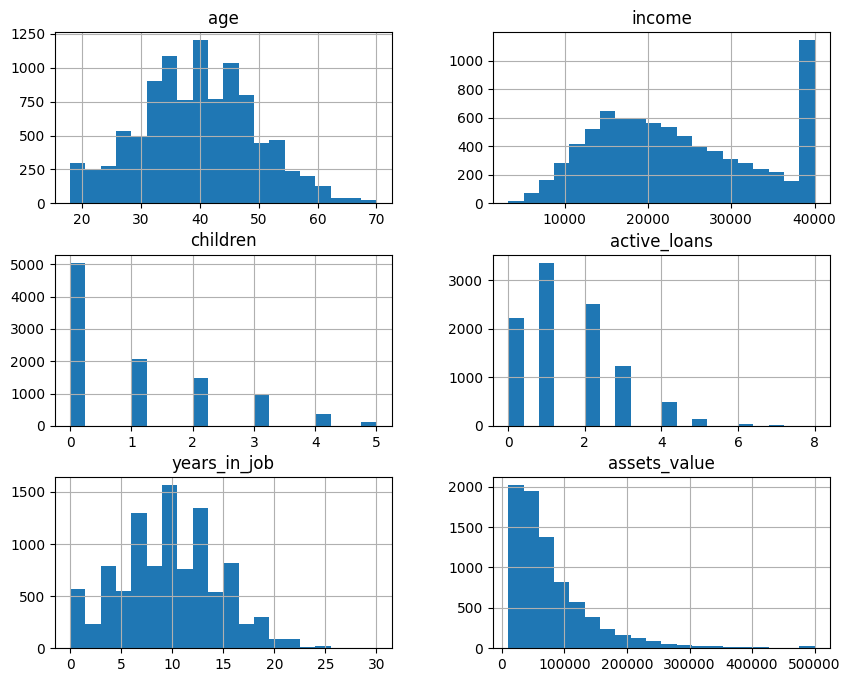

In [8]:
data[['age','income','children','active_loans','years_in_job','assets_value']].hist(bins=20, figsize=(10, 8))
plt.show()

`age` supposed to has a normal distribution

In [9]:
# Shapiro-Wilk test
sample = np.random.choice(data["age"], size=5000, replace=False)
stat, p = shapiro(sample)

# D'Agostino's K-squared test
stat1, p1 = normaltest(data["age"])

print("Shapiro-Wilk Test: p=%10f" %(p))
print("D'Agostino's K-squared Test: p=%.10f" %(p1))

Shapiro-Wilk Test: p=  0.000000
D'Agostino's K-squared Test: p=0.0000000013


In both tests p value is less than 0.05, so we can reject the null hypothesis and say that the age is not normally distributed.

So let's try to build a model without any transformation on the data. I will use the Random Forest Classifier as a baseline model. Let's check what we will get and then we will try to improve the model using different techniques.

In [10]:
X = data.drop('credit_risk', axis=1)
y = data['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [12]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1935
           1       1.00      0.65      0.79        65

    accuracy                           0.99      2000
   macro avg       0.99      0.82      0.89      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
[[1935    0]
 [  23   42]]
ROC AUC Score: 0.870494931425164
Accuracy: 0.9885


In [13]:
data.isna().sum()

age                    0
income              2000
children               0
credit_history      2000
overdue_payments    2000
active_loans           0
years_in_job           0
employment_type        0
owns_property       2000
assets_value        2000
other_loans            0
education              0
city                   0
marital_status         0
credit_risk            0
dtype: int64

Model's accuracy is 0.9885, this is very good. But let's check the confusion matrix we can note very large difference between the number of samples in each class. So we can't rely on the accuracy only. We need to check the precision, recall, and F1 score. F1 score is 0.89 it is good, but we can try to improve it. Recall for class 1 is 0.65 it is very low, so we need to find a way to improve it, because model says to give a credid for people who are not creditworthy( this can be dangerous for the bank).

### Delete the anomalies from the data

The data contains some anomalies, such as individuals who have been employed since an age younger than 14. Therefore, we need to remove these observations from the dataset.

In [14]:
data_clean_anomalies = data.drop(data[data["age"] - data["years_in_job"] < 14].index)

In [15]:
len(data_clean_anomalies)

9313

687 rows were removed from the dataset.

Now build random forest model again on the data without anomalies.

In [16]:
X = data_clean_anomalies.drop('credit_risk', axis=1)
y = data_clean_anomalies['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [18]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1801
           1       1.00      0.50      0.67        62

    accuracy                           0.98      1863
   macro avg       0.99      0.75      0.83      1863
weighted avg       0.98      0.98      0.98      1863

Confusion Matrix:
[[1801    0]
 [  31   31]]
ROC AUC Score: 0.8870116960111766
Accuracy: 0.9833601717659689


We can note that accuracy is 0.9883, this is lower than the previous model. More dramatically the recall for class 1 is 0.5 which is very low. F1-score also decreased to 0.83 from 0.89, the reason for that may be the fact of decreasing the number of samples of class 1 in the data, which was already low, before removing the anomalies.

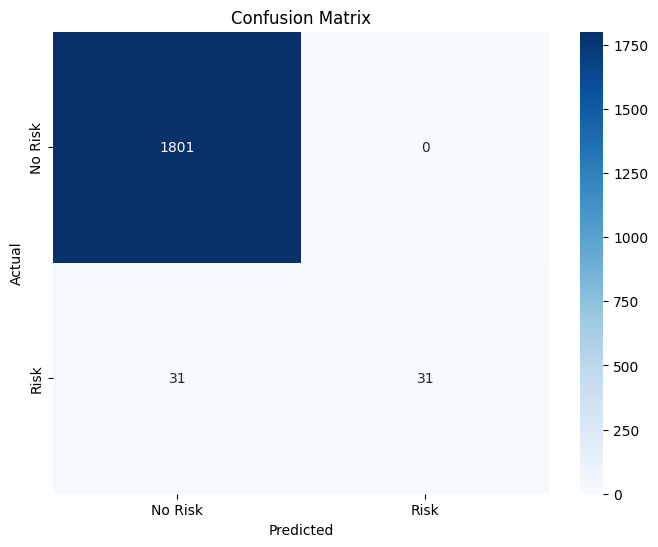

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### One Hot Encoding

In [20]:
data_one_hot = data_clean_anomalies.copy(deep=True)

In [21]:
children_dum = pd.get_dummies(data_one_hot["children"], prefix="children").astype(int)
data_one_hot = pd.concat([data_one_hot.drop("children", axis=1), children_dum], axis=1)

employment_dum = pd.get_dummies(data_one_hot["employment_type"], prefix="employment_type").astype(int)
data_one_hot = pd.concat([data_one_hot.drop("employment_type", axis=1), employment_dum], axis=1)

education_dum = pd.get_dummies(data_one_hot["education"], prefix="education").astype(int)
data_one_hot = pd.concat([data_one_hot.drop("education", axis=1), education_dum], axis=1) 

city_dum = pd.get_dummies(data_one_hot["city"], prefix="city").astype(int)
data_one_hot = pd.concat([data_one_hot.drop("city", axis=1), city_dum], axis=1)

marital_status_dum = pd.get_dummies(data_one_hot["marital_status"], prefix="marital_status").astype(int)
data_one_hot = pd.concat([data_one_hot.drop("marital_status", axis=1), marital_status_dum], axis=1)

In [22]:
data_one_hot.head()

,age,income,credit_history,overdue_payments,active_loans,years_in_job,owns_property,assets_value,other_loans,credit_risk,...,employment_type_3,education_0,education_1,education_2,city_0,city_1,city_2,marital_status_0,marital_status_1,marital_status_2
0,44,15689.0,1,0,2,9,<NA>,NaN,1,0,...,0,0,0,1,1,0,0,0,1,0
1,38,18906.0,0,0,0,1,1,62965.0,0,0,...,1,0,1,0,0,1,0,1,0,0
2,46,16338.0,<NA>,<NA>,2,4,1,124967.0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,55,23276.0,1,1,2,10,1,52147.0,1,0,...,1,0,1,0,1,0,0,1,0,0
4,37,40000.0,0,<NA>,1,9,0,33957.0,1,0,...,0,0,0,1,1,0,0,1,0,0


In [23]:
data_one_hot["active_loans"].value_counts()

active_loans
1    3125
2    2361
0    2066
3    1133
4     461
5     124
6      30
7      10
8       3
Name: count, dtype: int64

In [ ]:
# Обираємо потрібні колонки
columns_to_check = ['age', 'income', 'active_loans', 'years_in_job', 'assets_value']

# Розрахунок IQR і виявлення викидів
outliers = {}
for col in columns_to_check:
    Q1 = data_one_hot[col].quantile(0.25)
    Q3 = data_one_hot[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = data_one_hot[(data_one_hot[col] < lower_bound) | (data_one_hot[col] > upper_bound)][col]

outliers_summary = {col: len(outliers[col]) for col in outliers}
outliers_summary

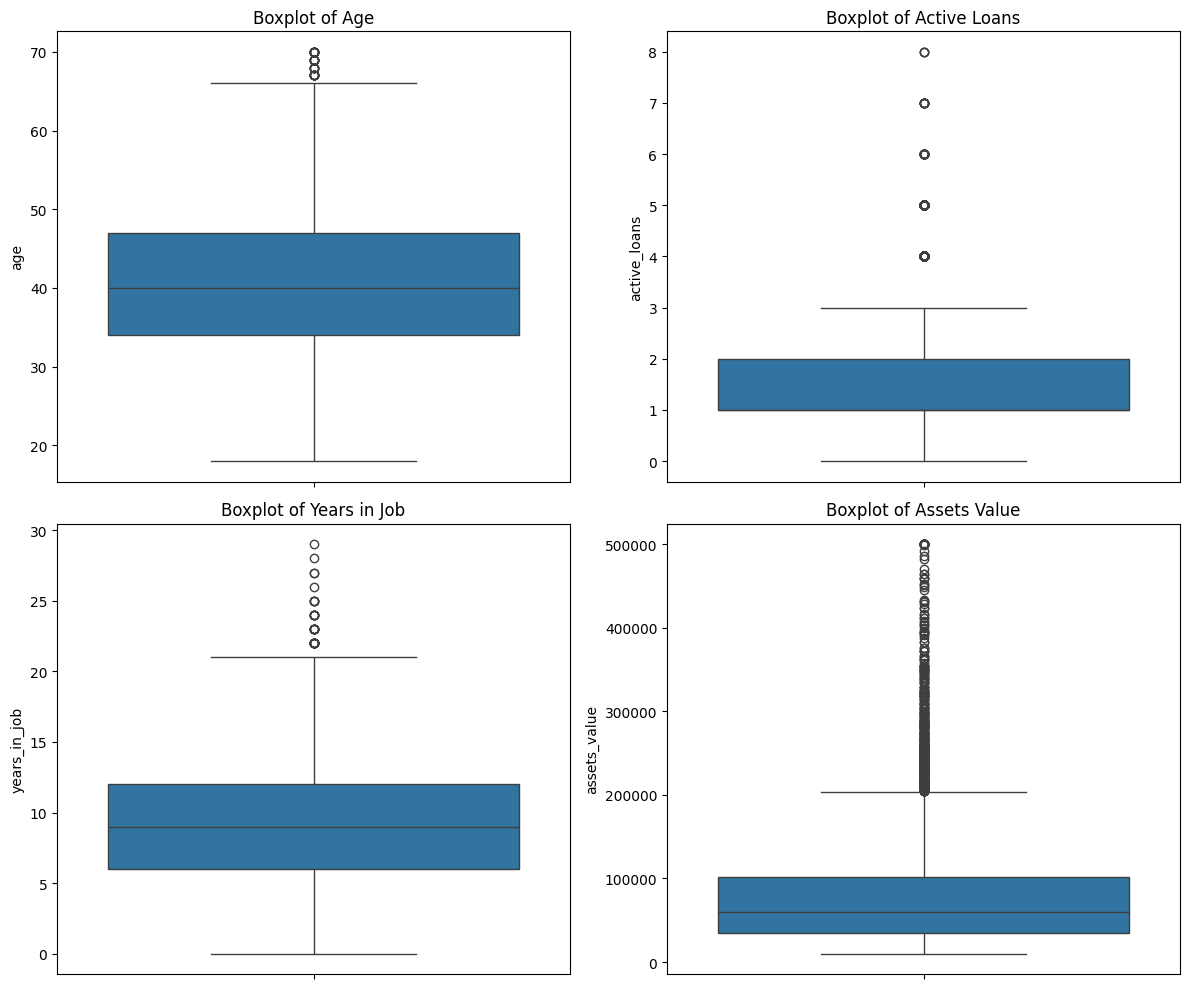

In [ ]:
# Creating boxplots for the specified variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

columns_to_plot = ['age', 'active_loans', 'years_in_job', 'assets_value']
titles = ['Age', 'Active Loans', 'Years in Job', 'Assets Value']

for ax, col, title in zip(axes.flatten(), columns_to_plot, titles):
    sns.boxplot(y=data_one_hot[col], ax=ax)
    ax.set_title(f'Boxplot of {title}')

plt.tight_layout()
plt.show()


### KNN Impuation

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_one_hot), columns=data_one_hot.columns)

### Build Random Forest Regression on One Hot Encoded Data

In [42]:
X = data_imputed.drop('credit_risk', axis=1)
y = data_imputed['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1801
         1.0       1.00      0.50      0.67        62

    accuracy                           0.98      1863
   macro avg       0.99      0.75      0.83      1863
weighted avg       0.98      0.98      0.98      1863

Confusion Matrix:
[[1801    0]
 [  31   31]]
ROC AUC Score: 0.8749440275115975
Accuracy: 0.9833601717659689


After one hot encoding we got the same accuracy as before 0.9883, recall and f1-score are also the same as before.

Confusion matrix are also the same as before, so there is no sense to visualize it again.

### SMOTE

In [45]:
data_imputed['credit_risk'].value_counts()

credit_risk
0.0    9004
1.0     309
Name: count, dtype: int64

In [46]:
X = data_imputed.drop('credit_risk', axis=1)
y = data_imputed['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Original training set class distribution:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("\nResampled training set class distribution:")
print(pd.Series(y_train_sm).value_counts())

Original training set class distribution:
credit_risk
0.0    7203
1.0     247
Name: count, dtype: int64

Resampled training set class distribution:
credit_risk
0.0    7203
1.0    7203
Name: count, dtype: int64


Smote made classes in the data balanced, so we can build a model on this data.

In [57]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train_sm, y_train_sm)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [58]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1801
         1.0       1.00      0.47      0.64        62

    accuracy                           0.98      1863
   macro avg       0.99      0.73      0.81      1863
weighted avg       0.98      0.98      0.98      1863

Confusion Matrix:
[[1801    0]
 [  33   29]]
ROC AUC Score: 0.8754141964141786
Accuracy: 0.9822866344605475


After SMOTE technique accuracy decreased not much, recall and f1-score also decreased for class 1, so should try to find other techniques to improve the model.

As our data contains a lot categorical columns, we can try to use the CatBoost model, which is very good for this type of data. Also instead of SMOTE we will increase the weight of class 1 in the model.

## Build CatBoost Classifier

In [336]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv("bank_data.csv", index_col=0)
data = data.drop(columns=['support_indicator '])
data = data.drop(data[data["age"] - data["years_in_job"] < 14].index)

# Convert currency columns to float
data["income"] = data["income"].str.replace("złoty", "").astype(float)
data["assets_value"] = data["assets_value"].str.replace("złoty", "").astype(float)

In [337]:
# Define categorical columns
cat_features = ["children", "credit_history", "overdue_payments", 
                "employment_type", "owns_property", "education", "city", "marital_status"]

# Separate numerical and categorical features
num_features = [col for col in X.columns if col not in cat_features]

In [338]:
# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNNImputer to the 'income' and 'assets_value' columns
data[['income', 'assets_value']] = knn_imputer.fit_transform(data[['income', 'assets_value']])

In [339]:
# 🔹 **3️⃣ Business Rules for Categorical Features**
data["credit_history"] = data.groupby("city")["credit_history"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "No Credit History"))
data["overdue_payments"] = data.groupby("employment_type")["overdue_payments"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "No Overdue Payments"))
data["owns_property"] = data.groupby("marital_status")["owns_property"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [340]:
data.isnull().sum()

age                 0
income              0
children            0
credit_history      0
overdue_payments    0
active_loans        0
years_in_job        0
employment_type     0
owns_property       0
assets_value        0
other_loans         0
education           0
city                0
marital_status      0
credit_risk         0
dtype: int64

In [341]:
data[cat_features] = data[cat_features].astype(str)

In [348]:
X = data.drop('credit_risk', axis=1)
y = data['credit_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Adjust class weights dynamically based on dataset distribution
risk_weight = len(y_train) / (2 * sum(y_train))  # More weight for Risk (minority class)
no_risk_weight = len(y_train) / (2 * (len(y_train) - sum(y_train)))  # Less weight for No Risk

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    cat_features=cat_features, 
    class_weights={0: no_risk_weight, 1: risk_weight}, 
    random_seed=42,
    verbose=200
)

# Train model
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=200)

# Predict
y_pred = model.predict(X_test)

0:	learn: 0.9223106	test: 0.9516757	best: 0.9516757 (0)	total: 46.1ms	remaining: 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9825019267
bestIteration = 102

Shrink model to first 103 iterations.


In [349]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1801
           1       0.94      0.97      0.95        62

    accuracy                           1.00      1863
   macro avg       0.97      0.98      0.98      1863
weighted avg       1.00      1.00      1.00      1863

Confusion Matrix:
[[1797    4]
 [   2   60]]
ROC AUC Score: 0.9863337572316455
Accuracy: 0.9967793880837359


In [352]:
import pandas as pd

# Get misclassified indexes
misclassified_indexes = (y_test != y_pred)

# Extract misclassified observations
misclassified_samples = X_test[misclassified_indexes].copy()
misclassified_samples["True_Label"] = y_test[misclassified_indexes]
misclassified_samples["Predicted_Label"] = y_pred[misclassified_indexes]
misclassified_samples["Confidence_to_1"] = y_pred_proba[misclassified_indexes]

In [353]:
misclassified_samples

,age,income,children,credit_history,overdue_payments,active_loans,years_in_job,employment_type,owns_property,assets_value,other_loans,education,city,marital_status,True_Label,Predicted_Label,Confidence_to_1
7604,43,5923.0,1 dzieci,dobra historia,brak opóźnień,2,0,określona,tak,54353.4,0,podstawowe,małe,kawaler/panna,0,1,0.748551
4327,49,5951.0,1 dzieci,dobra historia,brak opóźnień,1,1,samozatrudnienie,tak,31248.0,1,średnie,duże,żonaty/zamężna,0,1,0.848587
2923,39,6068.0,brak,dobra historia,brak opóźnień,2,15,określona,tak,46830.0,0,podstawowe,średnie,żonaty/zamężna,0,1,0.838033
5558,39,22543.8,4 dzieci,dobra historia,brak opóźnień,1,7,stała,nie,56577.0,0,podstawowe,średnie,kawaler/panna,1,0,0.061400
4442,45,38646.0,brak,brak historii,brak opóźnień,2,0,stała,tak,100126.8,0,średnie,duże,żonaty/zamężna,1,0,0.103585
1088,37,5046.0,4 dzieci,dobra historia,brak opóźnień,0,16,stała,tak,37501.0,1,podstawowe,średnie,żonaty/zamężna,0,1,0.539884


## Save and Load the Model

In [354]:
model.save_model("catboost_credit_risk.cbm")

In [311]:
from catboost import CatBoostClassifier
loaded_model = CatBoostClassifier()
loaded_model.load_model("catboost_credit_risk.cbm")